# 8.3.2 Data FORMAT Converter

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import sys
import os
import multiprocessing as mp
import time
from tqdm import tqdm
import numexpr
import numpy as np
from skimage import transform, io
import h5py
import tomopy
import dxchange
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipyfilechooser import FileChooser

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Choose the data file you want to convert

In [8]:
dataDir = "/global/cfs/cdirs/als/users/tomography_notebooks/example_data/old_format" # where is the raw data?
file_chooser = FileChooser(dataDir)
file_chooser.filter_pattern = '*.h5' # only show .h5 files
file_chooser.title = f'Choose data file'
display(file_chooser)

FileChooser(path='/global/cfs/cdirs/als/users/tomography_notebooks/example_data/old_format', filename='', titl…

### Choose where to save the converted data file

In [39]:
save_file_chooser = FileChooser(os.getcwd())
save_file_chooser.show_only_dirs = True
save_file_chooser.title = f'Choose data file'
display(save_file_chooser)

FileChooser(path='/global/u1/d/dperl/als_tomo/data_notbooks', filename='', title='Choose data file', show_hidd…

### Run this cell -- its contains the function to read old data 

In [40]:
#for files 0 and 1, there are two tiles each (so set whichtile to either  0 and 1).
#For the rest of the files, there is just a single tile, which means you need to set whichtile to negative
#because the hdf5 layout is different for tiled vs non-tiled datd

def read_OI_2012(fname, proj=None, sino=None, whichtile=-1):
    h5file = h5py.File(fname,'r')
    dname = fname.split('/')[-1].split('.')[0]
    grouppath = dname
    if whichtile>-1:
        tilepart = f"_x0y{whichtile}"
        grouppath = f"{grouppath}/{dname}{tilepart}"
    else:
        tilepart = ""
    flat_name = f"{dname}{tilepart}bak_0.tif"
    dark_name = f"{dname}{tilepart}drk_0.tif"
    tomo_name = f"{dname}{tilepart}_0.tif"
    thegroup = h5file[grouppath]
    nproj = 1201
    inter_bright = 120
    ind_dark = list(range(0, 10))
    ind_flat = list(range(0, nproj, inter_bright))
    if proj is not None:
        ind_tomo = proj
    else:
        ind_tomo = list(range(0, nproj))
    if sino is not None:
        ind_sino = sino
    else:
        ind_sino = (None, None)
    flat = dxchange.reader.read_hdf5_stack(thegroup, flat_name, ind_flat, slc=ind_sino, out_ind=None)
    dark = dxchange.reader.read_hdf5_stack(thegroup, dark_name, ind_dark, slc=ind_sino, out_ind=None)
    tomo = dxchange.reader.read_hdf5_stack(thegroup, tomo_name, ind_tomo, slc=ind_sino, out_ind=None)

    # tomo = tomo.astype(np.float32,copy=False)
    # tomopy.normalize(tomo, flat, dark, out=tomo)
    # tomopy.minus_log(tomo, out=tomo)

    # angle_offset = 270 # hardcoded from Dula's tomopyALS_Acevedo.ipynb
    angle_offset = 0
    anglelist = tomopy.angles(numangles, angle_offset, angle_offset - angularrange)
    anglelist = anglelist[ind_tomo]
        
    return tomo, flat, dark, anglelist

def read_als_832_format(path, proj=None, sino=None):
    tomo, flat, dark, floc = dxchange.read_als_832h5(path, proj=proj,sino=sino)

    angle_offset = 0
    anglelist = tomopy.angles(numangles, angle_offset, angle_offset-angularrange)
    if proj is not None:
        anglelist = anglelist[proj]
    
    return tomo, flat, dark, anglelist

### Choose old data format
* **OI_2012**: If this dataset has tiles, set the "whichtiletodo" to choose. Otherwise set to -1, because the hdf5 layout is different for tiled vs non-tiled data <br>
* **als_832** <br>

In [41]:
format_choices = widgets.Dropdown(
    options=['OI 2012', 'als_832'],
    value='als_832',
    description='<font size=4>Old ALS format options:',
    disabled=False,
    style={'description_width': 'initial'} # this makes sure description text doesn't get cut off
)
display(format_choices)

Dropdown(description='<font size=4>Old ALS format options:', index=1, options=('OI 2012', 'als_832'), style=De…

### Load old data - this may take a some time if the data is large

In [42]:
whichtiletodo = -1 #put -1 for a single tile in the file, otherwise put 0, 1, ... for the tile you want.

file_format = format_choices.value
filename = file_chooser.selected_filename
path = os.path.join(dataDir, filename)

datafile =  h5py.File(path, 'r')
gdata = dict(dxchange.reader._find_dataset_group(datafile).attrs)
pxsize = np.asarray(float(gdata['pxsize'])/10)
numslices = np.asarray(int(gdata['nslices']))
numangles = np.asarray(int(gdata['nangles']))
angularrange = np.asarray(float(gdata['arange']))
numrays = np.asarray(int(gdata['nrays']))
kev = np.asarray([0])
propagation_dist = np.asarray([0])
inter_bright = np.asarray([0])
energy = np.asarray([0])
camera_distance = np.asarray([0,0])

print(f'{filename}: \nslices: {numslices}, rays: {numrays}, angles: {numangles}, angularrange: {angularrange}, \npxsize: {pxsize*10000} um')# , distance: {propagation_dist} mm. energy: {kev} keV')

if file_format == "OI_2012": 
    full_tomo, full_flat, full_dark, full_angles = read_OI_2012(path, proj=None, sino=None, whichtile=whichtiletodo)
elif file_format == "als_832":
    full_tomo, full_flat, full_dark, full_angles = read_als_832_format(path, proj=None, sino=None)
else:
    print('Error: didnt recognize that old file format')

20190501_122704_spiderman_try3.h5: 
slices: 980, rays: 2560, angles: 985, angularrange: 180.0, 
pxsize: 0.641 um


/global/common/software/als/battery/conda/envs/als832/lib/python3.9/site-packages/dxchange/reader.py:1103: FutureWarning: The 'digit' argument is deprecated and no longer used.  It may be removed completely in a later version.
  warnings.warn(("The 'digit' argument is deprecated and no longer used."


### Look through projections, if you want

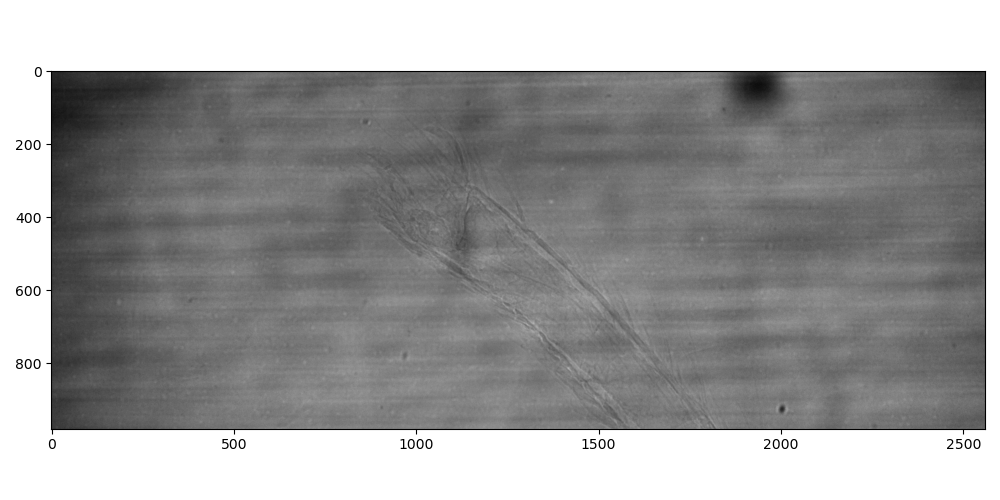

In [43]:
clim = [full_tomo.min(),full_tomo.max()]
if plt.fignum_exists(1): plt.close(1)
fig, axs = plt.subplots(1,1,num=1,figsize=(10, 5))
img = axs.imshow(full_tomo[0],cmap='gray',vmin=clim[0],vmax=clim[1])
plt.tight_layout()

def set_proj(i):
    img.set_data(full_tomo[i])
def set_clim(clims):
    img.set_clim(vmin=clims[0],vmax=clims[1]) 
    
proj_slider = widgets.interactive(set_proj, description='Projection',
                                  i=widgets.IntSlider(min=0, max=len(full_tomo)-1, step=1, value=0))
clim_slider = widgets.interactive(set_clim,
                                  clims=widgets.FloatRangeSlider(description='Color Scale', layout=widgets.Layout(width='50%'),
                                                                 min=clim[0], max=clim[-1],
                                                                 step=(clim[-1]-clim[0])/500, value=img.get_clim()))
ui = widgets.VBox([proj_slider, clim_slider])
display(ui)

### Save in new ALS 832 hdf5 format

In [44]:
new_file = filename if whichtiletodo < 0 else os.path.splitext(filename)[0] + f"_tile-{whichtiletodo}.h5"
if os.path.exists(os.path.join(save_file_chooser.selected_path, new_file)):
    os.remove(os.path.join(save_file_chooser.selected_path, new_file))
with h5py.File(os.path.join(save_file_chooser.selected_path, new_file),'a') as f:
    det = f.create_group("measurement/instrument/detector")
    det.create_dataset("dimension_y", data=np.asarray(numslices)[np.newaxis])
    det.create_dataset("dimension_x", data=np.asarray(numrays)[np.newaxis])
    det.create_dataset("pixel_size", data=np.asarray(pxsize*10.0)[np.newaxis])
    f.create_dataset("/process/acquisition/flat_fields/i0cycle",data=np.asarray(inter_bright)[np.newaxis])
    f.create_dataset("/process/acquisition/flat_fields/num_flat_fields",data=np.asarray(len(full_flat))[np.newaxis])
    f.create_dataset("/process/acquisition/dark_fields/num_dark_fields",data=np.asarray(len(full_dark))[np.newaxis])  
    f.create_dataset("measurement/instrument/camera_motor_stack/setup/camera_distance",data=camera_distance)
    f.create_dataset("measurement/instrument/monochromator/energy",data=energy)
    rot = f.create_group("process/acquisition/rotation")
    rot.create_dataset("num_angles", data=np.asarray(len(full_angles))[np.newaxis])
    rot.create_dataset("range", data=np.asarray(np.rad2deg(np.abs(full_angles[-1]-full_angles[0])))[np.newaxis])
    exch = f.create_group("exchange")
    exch.create_dataset("data", data=full_tomo)
    exch.create_dataset("data_white", data=full_flat)
    exch.create_dataset("data_dark", data=full_dark)
    exch.create_dataset("theta", data=np.rad2deg(full_angles))

# The rest is just for saving in as numpy array -- you don't need to run it

### Preprocess and save as .npz

In [ ]:
tomo = full_tomo.astype(np.float32,copy=True)
tomo = tomopy.normalize(tomo, full_flat, full_dark)
tomopy.minus_log(tomo, out=tomo)
anglelist = full_angles
print(tomo.shape, tomo.dtype)

In [ ]:
new_file = f"{os.path.splitext(filename)[0]}.npz" if whichtiletodo < 0 else os.path.splitext(filename)[0] + f"_tile-{whichtiletodo}.npz"
np.savez(os.path.join(saveDir,new_file),tomo=tomo,angles=anglelist)

### Downsample and save as .npz

In [ ]:
down_ang = 8
down_px = 8
def proj_down(projs,down_px):
    down = [transform.downscale_local_mean(proj, (down_px,down_px), cval=0).astype(proj.dtype) for proj in projs]
    return np.asarray(down)

In [ ]:
tomo_down = proj_down(tomo[0:numangles:down_ang],down_px)
anglelist_down = anglelist[0:numangles:down_ang]

In [ ]:
print(tomo_down.shape, tomo_down.dtype)
print(anglelist_down.shape, anglelist_down.dtype)

In [ ]:
if whichtiletodo < 0:
    new_file = f"down_{down_px}x{down_px}x{down_ang}x_{os.path.splitext(filename)[0]}.npz"
else:
    new_file = f"down_{down_px}x{down_px}x{down_ang}x_{os.path.splitext(filename)[0]}_tile-{whichtiletodo}.npz"
np.savez(os.path.join(saveDir,new_file),tomo=tomo_down,angles=anglelist_down)